# Coexisting processes (SIR + UAU) + multilayer (AUCS)

This experiment shows the difference between SIR and SIR + UAU

In [169]:
import functions
import models
import network_diffusion as nd
import networkx as nx
import numpy as np
import pandas as pd

from network_diffusion.models.utils.compartmental import CompartmentalGraph
from tqdm import tqdm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [161]:
N_EPOCHS = 30
N_REPETITIONS = 30
PATIENCE = None
LAMBDAS = [0, 0.5, 1, 1.5, 2]

In [162]:
net = nd.MultilayerNetwork.from_nx_layer(
    network_layer=nx.erdos_renyi_graph(n=100, p=0.2), layer_names=phenomena.keys()
)
print(net)

network parameters
--------------------------------------------
general parameters:
	number of layers: 2
	number of actors: 100

layer 'contagion' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 100
	number of edges - 999
	average degree - 19.98
	clustering coefficient - 0.1972

layer 'awareness' parameters:
	graph type - <class 'networkx.classes.graph.Graph'>
	number of nodes - 100
	number of edges - 999
	average degree - 19.98
	clustering coefficient - 0.1972


In [187]:
results = {}

for l in LAMBDAS:
    print(f"Model with lambda: {l}")
    model = models.get_flu_model(l=l)

    all_logs = []
    for i in tqdm(range(N_REPETITIONS)):
        experiment = nd.Simulator(model, net.copy())
        run_logs = experiment.perform_propagation(n_epochs=N_EPOCHS, patience=PATIENCE)
        all_logs.append(run_logs._global_stats_converted)

    mean_contagion = functions.get_mean_log([log["contagion"] for log in all_logs])
    mean_awareness = functions.get_mean_log([log["awareness"] for log in all_logs])
    mean_core = pd.DataFrame([mean_contagion["I"], mean_awareness["A"]]).T

    std_contagion = functions.get_std_log([log["contagion"] for log in all_logs])
    std_awareness = functions.get_std_log([log["awareness"] for log in all_logs])
    std_core = pd.DataFrame([std_contagion["I"], std_awareness["A"]]).T

    results[l] = {"mean": mean_core, "std": std_core}

Model with lambda: 0


100%|██████████| 30/30 [00:03<00:00,  9.34it/s]


Model with lambda: 0.5


100%|██████████| 30/30 [00:02<00:00, 10.30it/s]


Model with lambda: 1


100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


Model with lambda: 1.5


100%|██████████| 30/30 [00:02<00:00, 10.73it/s]


Model with lambda: 2


100%|██████████| 30/30 [00:02<00:00, 10.58it/s]


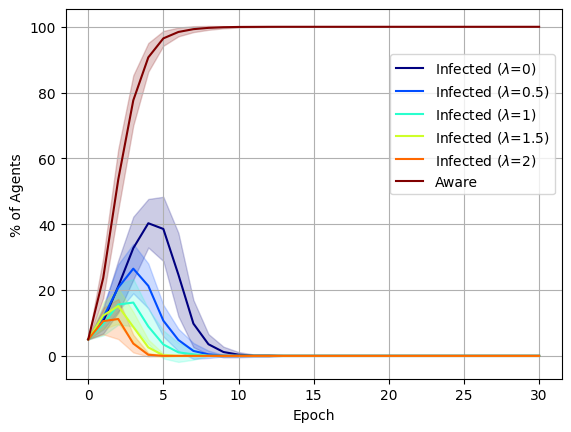

In [201]:
fig, ax = plt.subplots(nrows=1, ncols=1)
colors = plt.cm.jet(np.linspace(0, 1, len(results) + 1))
res_nb = 0

for l, result in results.items():

    _i = result["mean"]["I"].to_numpy()
    _i_std = result["std"]["I"].to_numpy()
    _x = np.arange(0, len(_i))

    # _x_new = np.linspace(_x.min(), _x.max(), 300)
    # _i_new = make_interp_spline(_x, _i, k=1)(_x_new)

    ax.plot(_x, _i, label=rf"Infected ($\lambda$={l})", color=colors[res_nb])
    ax.fill_between(_x, _i-_i_std, _i+_i_std, alpha=0.2, color=colors[res_nb])

    res_nb += 1


_a = np.array([_r["mean"]["A"] for _r in results.values()]).mean(0)
_a_std = np.array([_r["std"]["A"] for _r in results.values()]).mean(0)

ax.plot(_x, _a, label="Aware", color=colors[res_nb])
ax.fill_between(_x, _a-_a_std, _a+_a_std, alpha=0.2, color=colors[res_nb])

ax.grid(True)
ax.set_xlabel("Epoch")
ax.set_ylabel("% of Agents")
fig.legend(loc="upper right", bbox_to_anchor=(0.9, 0.8))
